In [5]:
import os
import cv2
import torch
import json
import numpy as np
from unet import UNet
from skimage import io
import matplotlib.pyplot as plt


In [6]:
# Load model
model_name = '5_10_3169'

f = open('./models/unet_params_'+model_name+'.json')
model_params = json.load(f)
f.close()

model = UNet(**model_params)
model.load_state_dict(torch.load('./models/unet_weights_'+model_name+'.pth'))

<All keys matched successfully>

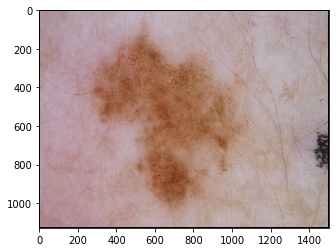

In [7]:
# Load image
img = io.imread('./ISIC/images/ISIC_0000021.png')

plt.imshow(img)
plt.show()

In [8]:
# make a prediction
img = cv2.resize(img, (256,256)) / 255.0
input = torch.tensor(img.transpose(2,0,1), dtype=torch.float).unsqueeze(0) 
output = model(input)


(2, 256, 256)


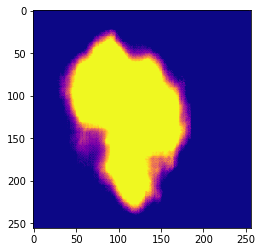

In [9]:
# plot prediction
out_mask = output.squeeze(0).detach().numpy().transpose(0,1,2)
print(out_mask.shape)

plt.imshow(out_mask[1], 'plasma', vmin=-1,vmax=1)
plt.show()

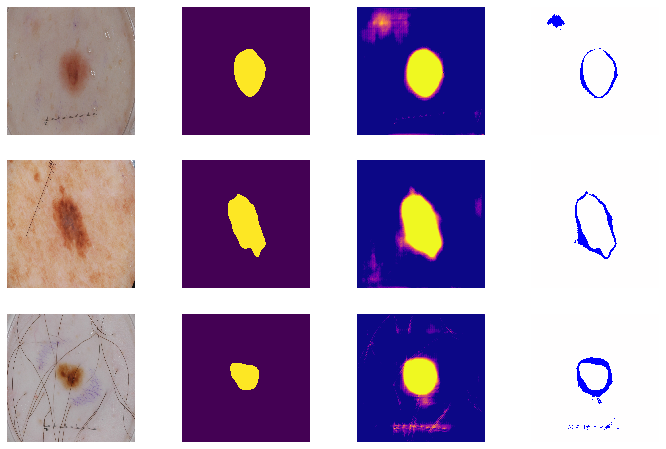

In [24]:
fig, ax = plt.subplots(3,4, figsize=(12,8))

images_filenames = sorted(os.listdir('data/validation/images'))
masks_filenames = sorted(os.listdir('data/validation/masks'))

for i in range(3):
    # load img
    offset = 100 #10 70 !90
    
    img = io.imread('./ISIC/images/'+str(images_filenames[offset+i])+'')
    mask = io.imread('./ISIC/masks/'+str(masks_filenames[offset+i]))
    
    img = cv2.resize(img, (256,256)) / 255.0
    mask = cv2.resize(mask, (256,256)) / 255.0
    
    # make a prediction
    input = torch.tensor(img.transpose(2,0,1), dtype=torch.float).unsqueeze(0) 
    output = model(input)
    out_mask = output.squeeze(0).detach().numpy().transpose(0,1,2)

    # plot stuff
    ax[i,0].imshow(img)
    ax[i,0].axis('off')
    ax[i,1].imshow(mask)
    ax[i,1].axis('off')
    ax[i,2].imshow(out_mask[1], 'plasma', vmin=-1,vmax=1)
    ax[i,2].axis('off')
    im = ax[i,3].imshow(mask - (out_mask[1]>0).astype(int), 'bwr', vmin=-1,vmax=1)
    ax[i,3].axis('off')
    
fig.show()

# ABC Feature extractor
[Contours in OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html#table-of-content-contours)

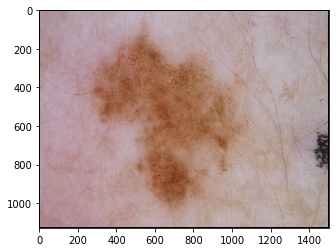

In [1]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import cv2

# load test image and mask
img = io.imread('ISIC/images/ISIC_0000021.png')
mask = (io.imread('ISIC/masks/ISIC_0000021_mask.png') / 255).astype(int)
plt.imshow(img, vmin=0,vmax=255)
# plt.imshow(mask, alpha=0.3)
plt.show()

mask = mask.reshape(mask.shape[0], mask.shape[1], 1)

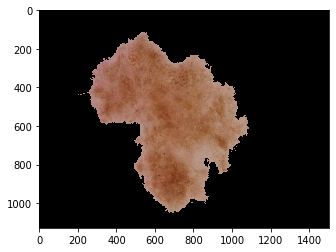

In [2]:
crop_img = img * mask
plt.imshow(crop_img)
plt.show()

## A - Asymmetry

In [3]:
'''
Find center of melanoma
'''
# [pix for pix in crop_img.sum(2) if pix > 0]

center = [0,0]
c_img = crop_img.sum(2)
count = np.sum(c_img > 0)

for x in range(crop_img.shape[0]):
    for y in range(crop_img.shape[1]):
        if c_img[x,y] != 0:
            center[1] += x
            center[0] += y

print(center)
center = (center / count).astype(int)
print(center)

[291425943, 240284339]
[675 557]


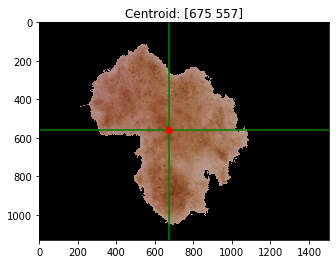

In [4]:
plt.imshow(crop_img)

plt.plot([center[0],center[0]], 
         [0,crop_img.shape[0]], 
         '-g')
plt.plot([0,crop_img.shape[1]], 
         [center[1],center[1]],
         '-g')

plt.plot(center[0], center[1], 'or')
plt.title('Centroid: {}'.format(center))
plt.xlim(0,crop_img.shape[1])
plt.ylim(crop_img.shape[0], 0)
plt.show()

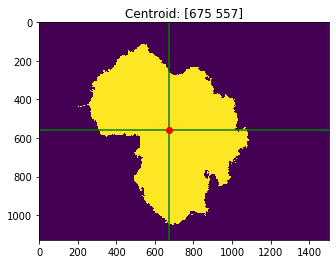

In [5]:
mask = cv2.imread('ISIC/masks/ISIC_0000021_mask.png', 0)
# print(mask.shape)
# print(np.unique(mask))


plt.plot([center[0],center[0]], 
         [0,crop_img.shape[0]], 
         '-g')
plt.plot([0,crop_img.shape[1]], 
         [center[1],center[1]],
         '-g')

plt.plot(center[0], center[1], 'or')
plt.title('Centroid: {}'.format(center))

plt.imshow(mask)
plt.show()

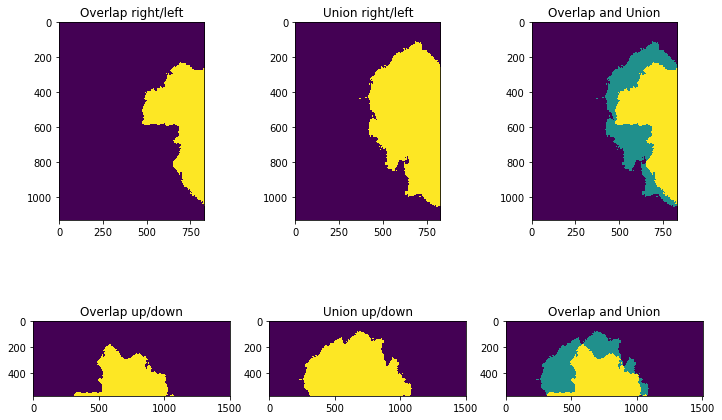

In [6]:
# get symmetry parts
right = mask[:,:center[0]] / 255
left = cv2.flip(mask[:,center[0]:], 1) / 255
up =  mask[:center[1],:] / 255
down = cv2.flip(mask[center[1]:,:], 0) / 255

# normilizing
if right.shape[1] > left.shape[1]:
    zz = np.zeros((right.shape[0],right.shape[1]-left.shape[1]))
    left = np.concatenate((zz,left), axis=1)
else:
    zz = np.zeros((left.shape[0],left.shape[1]-right.shape[1]))
    right = np.concatenate((zz,right), axis=1)

if up.shape[0] > down.shape[0]:
    zz = np.zeros((up.shape[0] - down.shape[0], up.shape[1]))
    down = np.concatenate((zz,down), axis=0)
else:
    zz = np.zeros((down.shape[0] - up.shape[0], down.shape[1]))
    up = np.concatenate((zz,up), axis=0)

vertical_union = right * left
vectical_overlap = (right + left > 0).astype(int)

horisontal_union = up * down
horisontal_overlap = (up + down > 0).astype(int) 

fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].imshow(vertical_union)
ax[0,0].set_title('Overlap right/left')
ax[0,1].imshow(vectical_overlap)
ax[0,1].set_title('Union right/left')
ax[0,2].imshow(vectical_overlap + vertical_union)
ax[0,2].set_title('Overlap and Union')

ax[1,0].imshow(horisontal_union)
ax[1,0].set_title('Overlap up/down')
ax[1,1].imshow(horisontal_overlap)
ax[1,1].set_title('Union up/down')
ax[1,2].imshow(horisontal_overlap + horisontal_union)
ax[1,2].set_title('Overlap and Union')

plt.show()

In [7]:
# 0 - assymetric; 1 - symmetric
vertical_symmetry = (vertical_union.sum() / vectical_overlap.sum())
horisontal_symmetry = (horisontal_union.sum() / horisontal_overlap.sum())
total_symmetry = (vertical_symmetry + horisontal_symmetry) / 2

print('Vertical symmetry:   {:2.2f}'.format(vertical_symmetry))
print('Horizontal symmetry: {:2.2f}'.format(horisontal_symmetry))
print('-'*25)
print('Total symmetry: {:2.2f}'.format(total_symmetry))

Vertical symmetry:   0.57
Horizontal symmetry: 0.53
-------------------------
Total symmetry: 0.55


## B - Border Irregularity

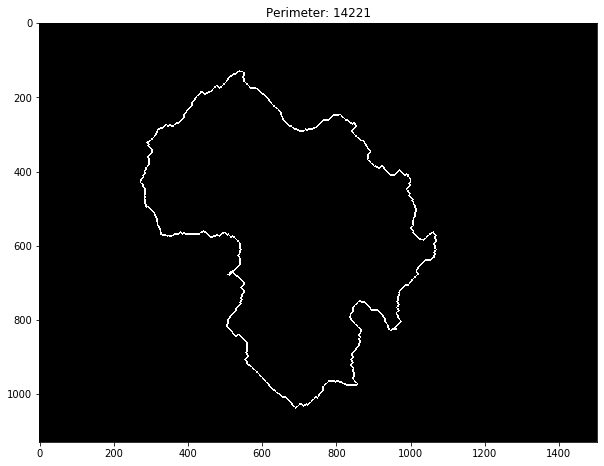

In [87]:
im, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

black_img = np.zeros(mask.shape)

img = cv2.drawContours(black_img, contours, -1, 255, 3)
plt.figure(figsize=(10,10))
plt.imshow(img, 'gray')
plt.title('Perimeter: {}'.format(int((img/255).sum())))
plt.show()

# im, contours, h = cv2.findContours(mask,1,2)
# cnt = contours[0]
# M = cv2.moments(cnt)
# print('Centroid:',int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
# area = cv2.contourArea(cnt)
# peremiter = cv2.arcLength(cnt,True)

14221.0

In [62]:
# epsilon = 0.1*cv2.arcLength(cnt,True)
# approx = cv2.approxPolyDP(cnt,epsilon,True)

# approx

array([[[ 530,  111]],

       [[ 700, 1054]]], dtype=int32)

## C - Color 